Making a new semi-empirical model. Draft for talks, proper one later 

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.convolution import convolve, Box1DKernel, convolve_fft, Gaussian1DKernel
from astropy.visualization import simple_norm
from photutils.aperture import aperture_photometry
from photutils.aperture import ApertureStats
import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from scipy.io import readsav

from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from astropy.time import Time
from scipy.optimize import leastsq


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v24_hlsp/TRAPPIST-1/'

In [8]:
phx = fits.getdata('{}hlsp_muscles_model_phx_trappist-1_na_v24_component-spec.fits'.format(path),1)
normfac = fits.getheader('{}hlsp_muscles_model_phx_trappist-1_na_v24_component-spec.fits'.format(path),0)['NORMFAC']
apec = fits.getdata('{}hlsp_muscles_model_apec_trappist-1_na_v24_component-spec.fits'.format(path),1)
dem = fits.getdata('{}../../dems/TRAPPIST-1/spectrum_trappist-1_p17.fits'.format(path), 1)

In [7]:
def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

In [41]:
pw, pf = phx['WAVELENGTH'], phx['FLUX']

pmask = (pw > 1000) & (pw < 1e6)
pwi, pfi = pw[pmask], pf[pmask]*normfac
# pwi, pfi = smear(pwi, pfi, 1000)

In [49]:
xw, xf = apec['WAVELENGTH'], apec['FLUX']
dw, df = dem['WAVELENGTH'], dem['FLUX_DENSITY']
mask = (dw > xw[-1]) & (dw < 1100)
dw, df = dw[mask], df[mask]

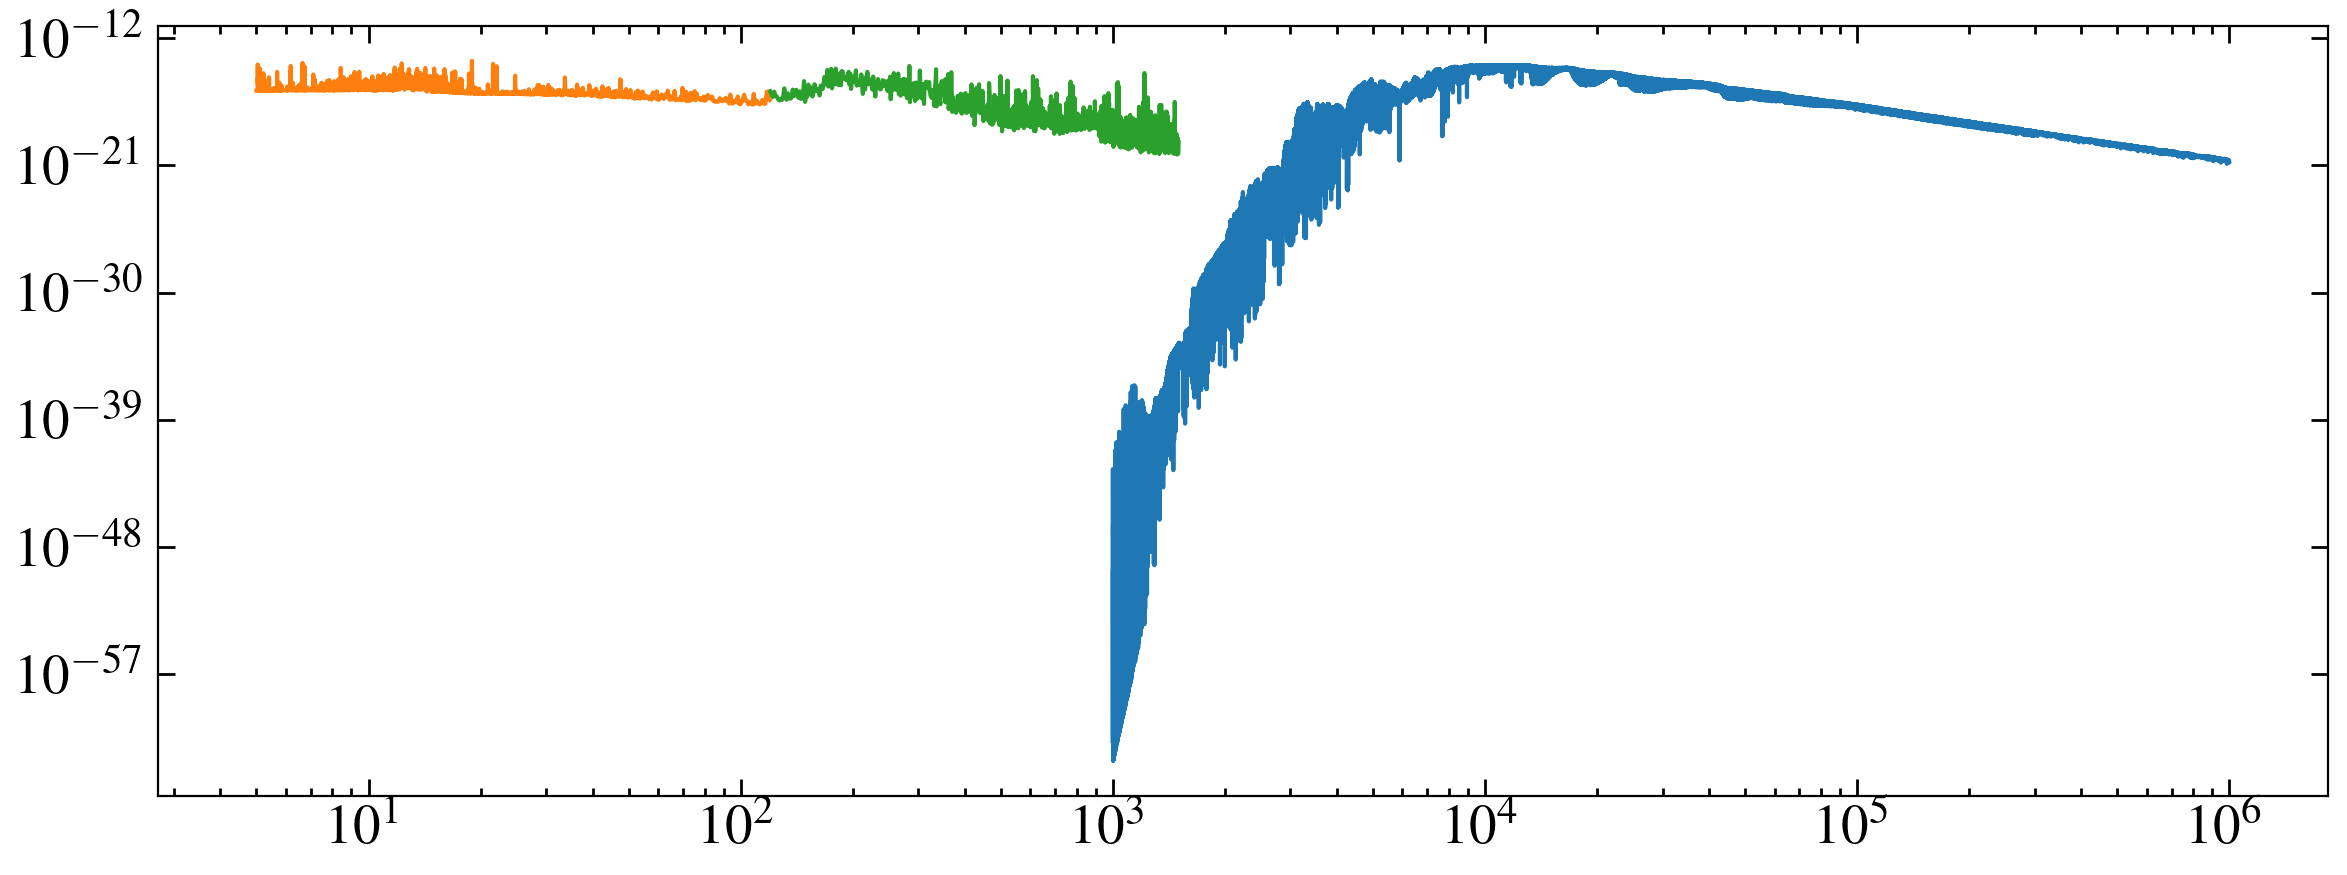

In [43]:
plt.plot(pwi, pfi)
plt.plot(xw, xf)
plt.plot(dw, df)
plt.yscale('log')
plt.xscale('log')

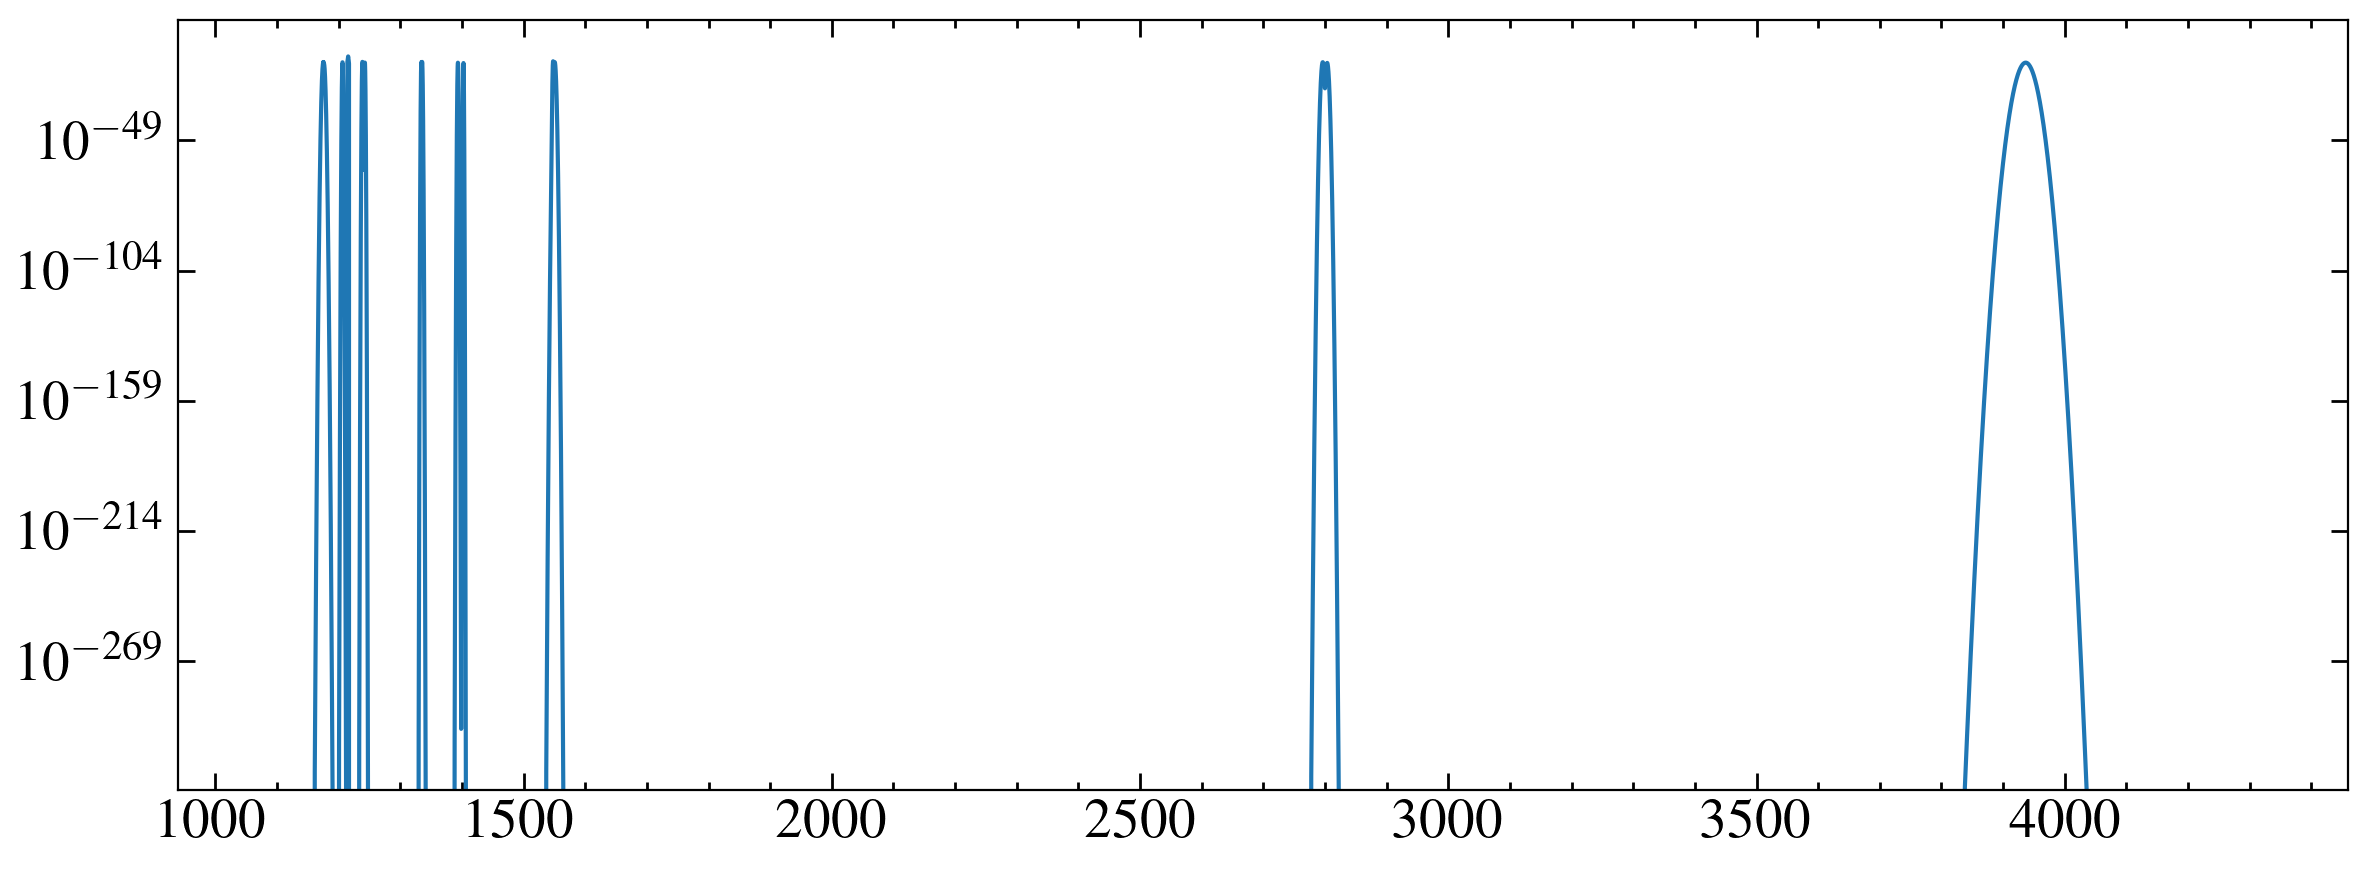

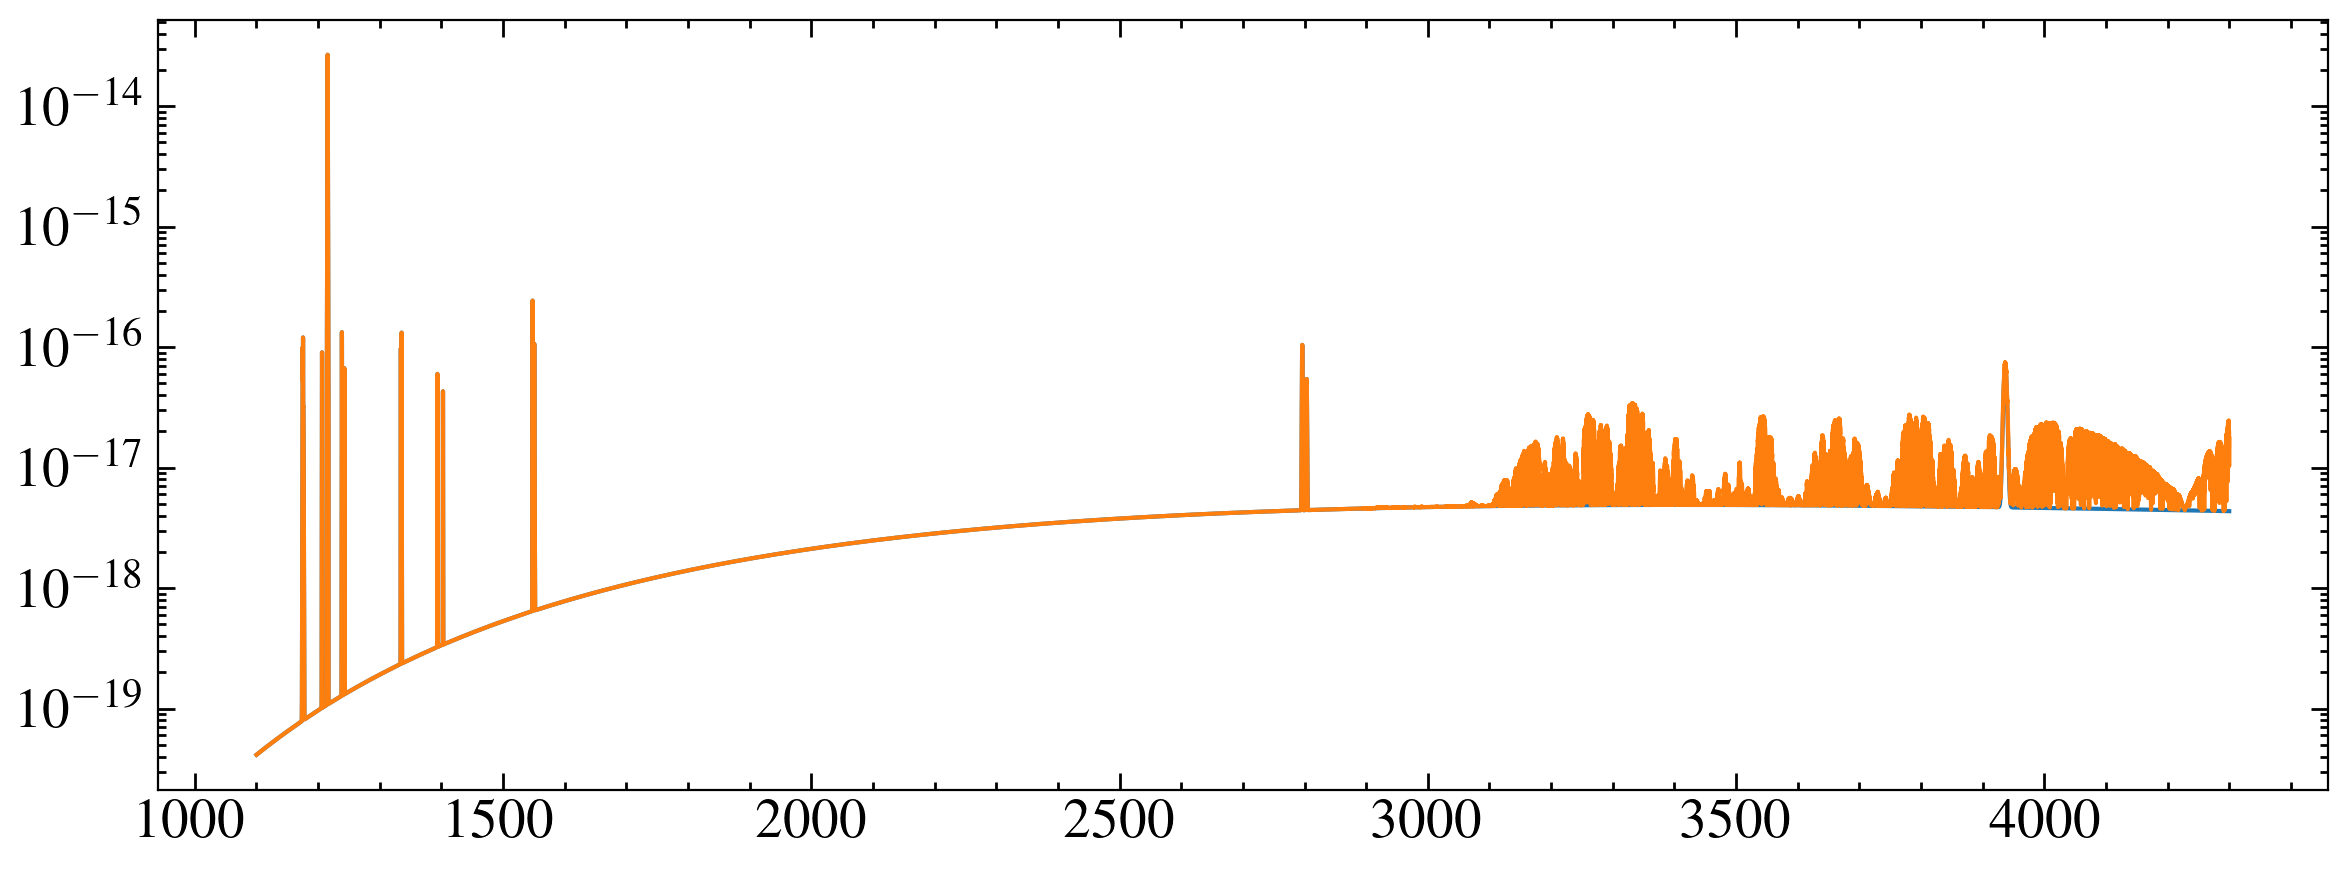

In [84]:
#lines
#put the model lines in one box

lines_mod = models.Const1D(0)

params = Table.read('../paper/emmision_lines_for.model.ecsv')
a, m, s, o= params['Amplitude'], params['Mean'], params['Stddev'], params['Offset']
mask = (a > 0 )& (m < 2750)
a, m, s, o = a[mask], m[mask], s[mask], o[mask]

a += -1*o
for i in range(len(a)):
    if i == 0:
        lines_mod = models.Gaussian1D(a[i], m[i], s[i])
    else:
        lines_mod = lines_mod + models.Gaussian1D(a[i], m[i], s[i])
#seperate ciii1176 lines
params = Table.read('../paper/ciii1176_lines_for.model.ecsv')
a, m, s, o= params['Amplitude'], params['Mean'], params['Stddev'], params['Offset']
mask = a > 0
a, m, s, o = a[mask], m[mask], s[mask], o[mask]
a += -1*o

for i in range(len(a)):
    lines_mod = lines_mod + models.Gaussian1D(a[i], m[i], s[i])
params = Table.read('../paper/ca_emmision_lines_for.model.ecsv')
a, m, s, o= params['Amplitude'], params['Mean'], params['Stddev'], params['Offset']
mask = a > 0
a, m, s, o = a[mask], m[mask], s[mask], o[mask]
a += -1*o

#for i in range(len(a)):
lines_mod = lines_mod + models.Gaussian1D(a[0], m[0], s[0]) #2nd line is an upper limit

mg2 = [2796.352, 2803.53]
mg_mod = models.Gaussian1D(amplitude=1e-16, mean = mg2[0], stddev=0.5, fixed = dict(mean=True, stddev=True)) + models.Gaussian1D(amplitude=0.5e-16, mean = mg2[1], stddev=0.5, fixed = dict(mean=True, stddev=True))

lines_mod += mg_mod

mw = np.arange(1100, 4300, 0.01)
#plt.plot(mw, lines_mod(mw))
mf = lines_mod(mw)

lya = Table.read('../lya/Trappist-1_lya_simple.txt', format='ascii')
#plt.plot(lya['WAVELENGTH'], lya['FLUX'])
lyaw, lyaf = lya['WAVELENGTH'][lya['FLUX'] > 0], lya['FLUX'][lya['FLUX'] > 0] 
lya_f_new = interp1d(lyaw, lyaf, bounds_error=False, fill_value=0)(mw)

mf += lya_f_new

#mg ii



plt.plot(mw, mf)
plt.yscale('log')

plt.show()

bb_mod = models.BlackBody(temperature=8500*u.K, scale=2.7e-25*u.erg/u.s/u.cm**2/u.AA/u.sr, fixed=dict(temperature=True, scale=True))
bb_f = bb_mod(mw)

mod_f = mf+bb_f.value

plt.plot(mw, mod_f)
plt.yscale('log')

# plt.show()

pmask = (pw > mw[0]) & (pw < mw[-1])
pw2, pf2 = pw[pmask], pf[pmask]*normfac
pf2 = interp1d(pw2, pf2, fill_value='extrapolate')(mw)

mod_f = mod_f + pf2

plt.plot(mw, mod_f)

In [85]:
pmask = (pw > 4300) & (pw < 1e6)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = smear(pwi, pfi, 100000)

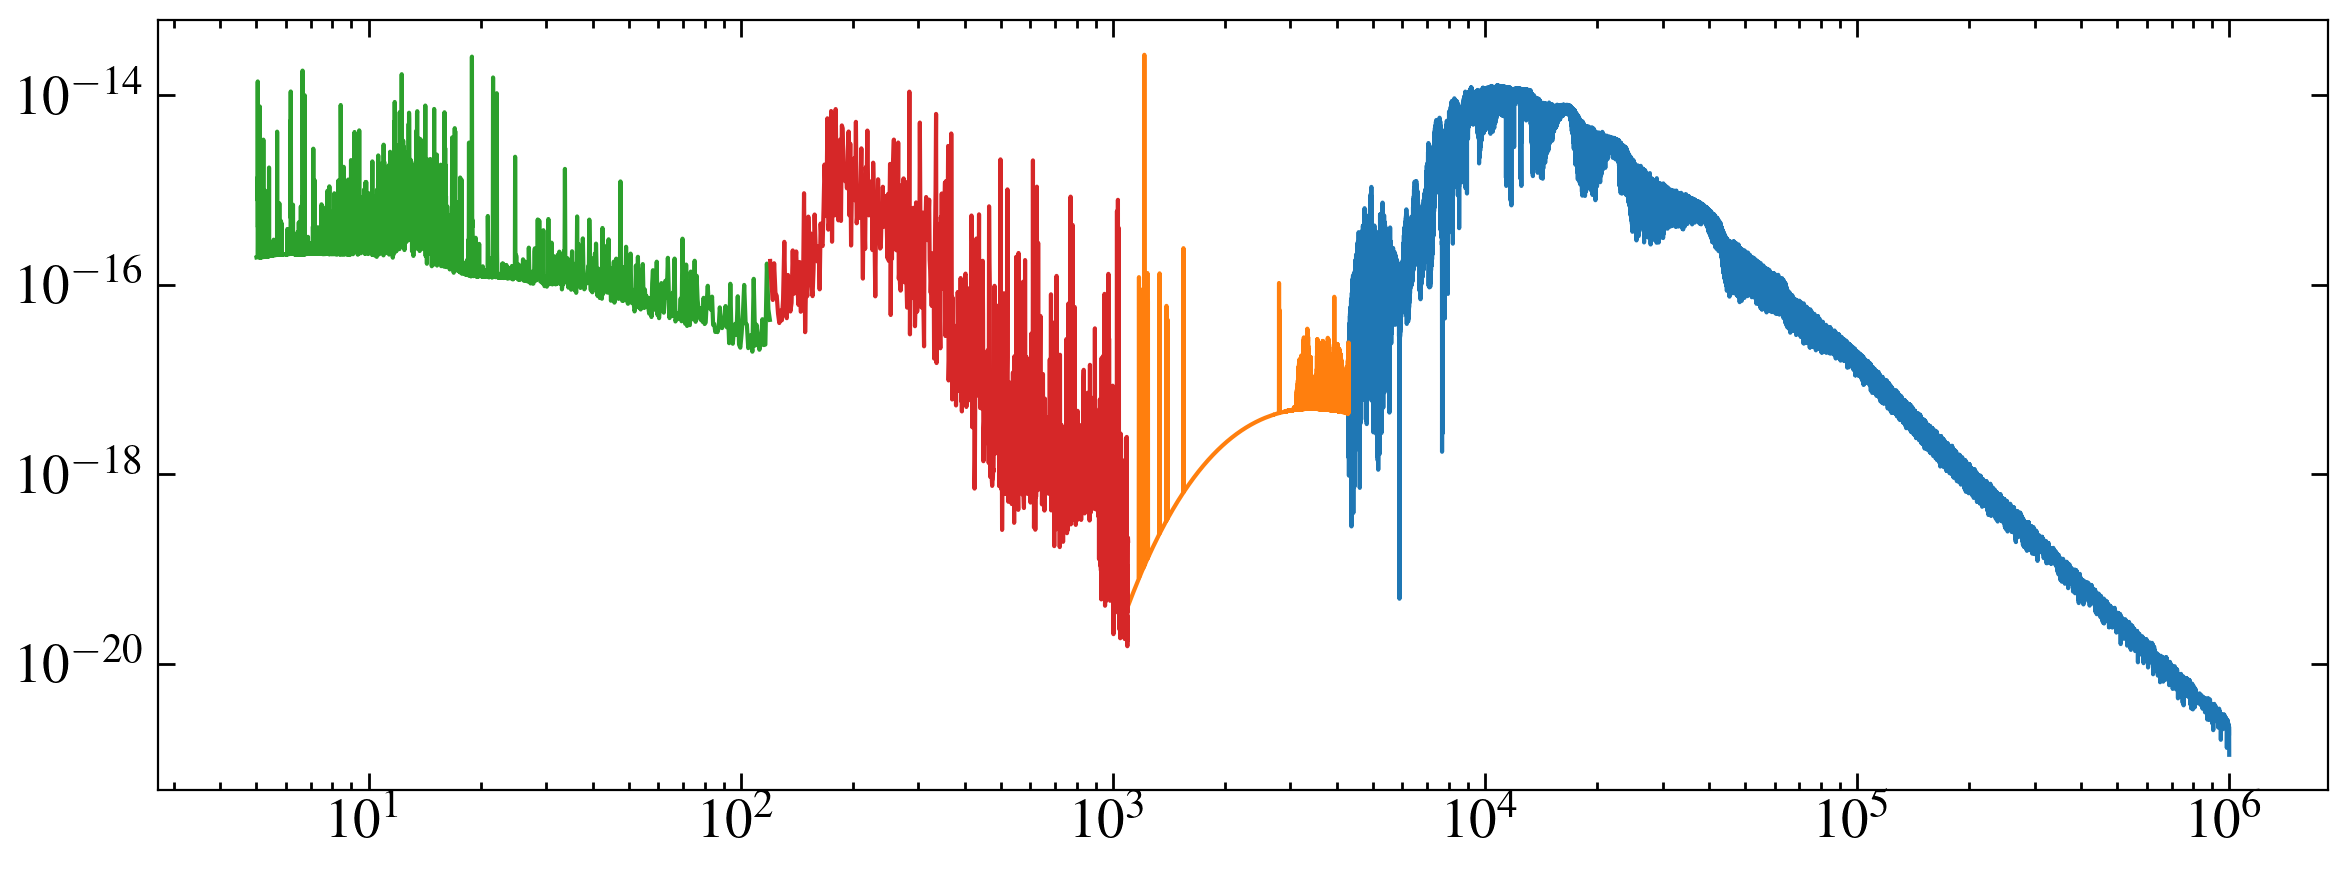

In [86]:
plt.plot(pwi, pfi)
plt.plot(mw, mod_f)
plt.plot(xw, xf)
plt.plot(dw, df)
plt.yscale('log')
plt.xscale('log')

In [87]:
t1w, t1f = np.hstack((xw, dw, mw, pwi)), np.hstack((xf, df, mod_f, pfi)) 

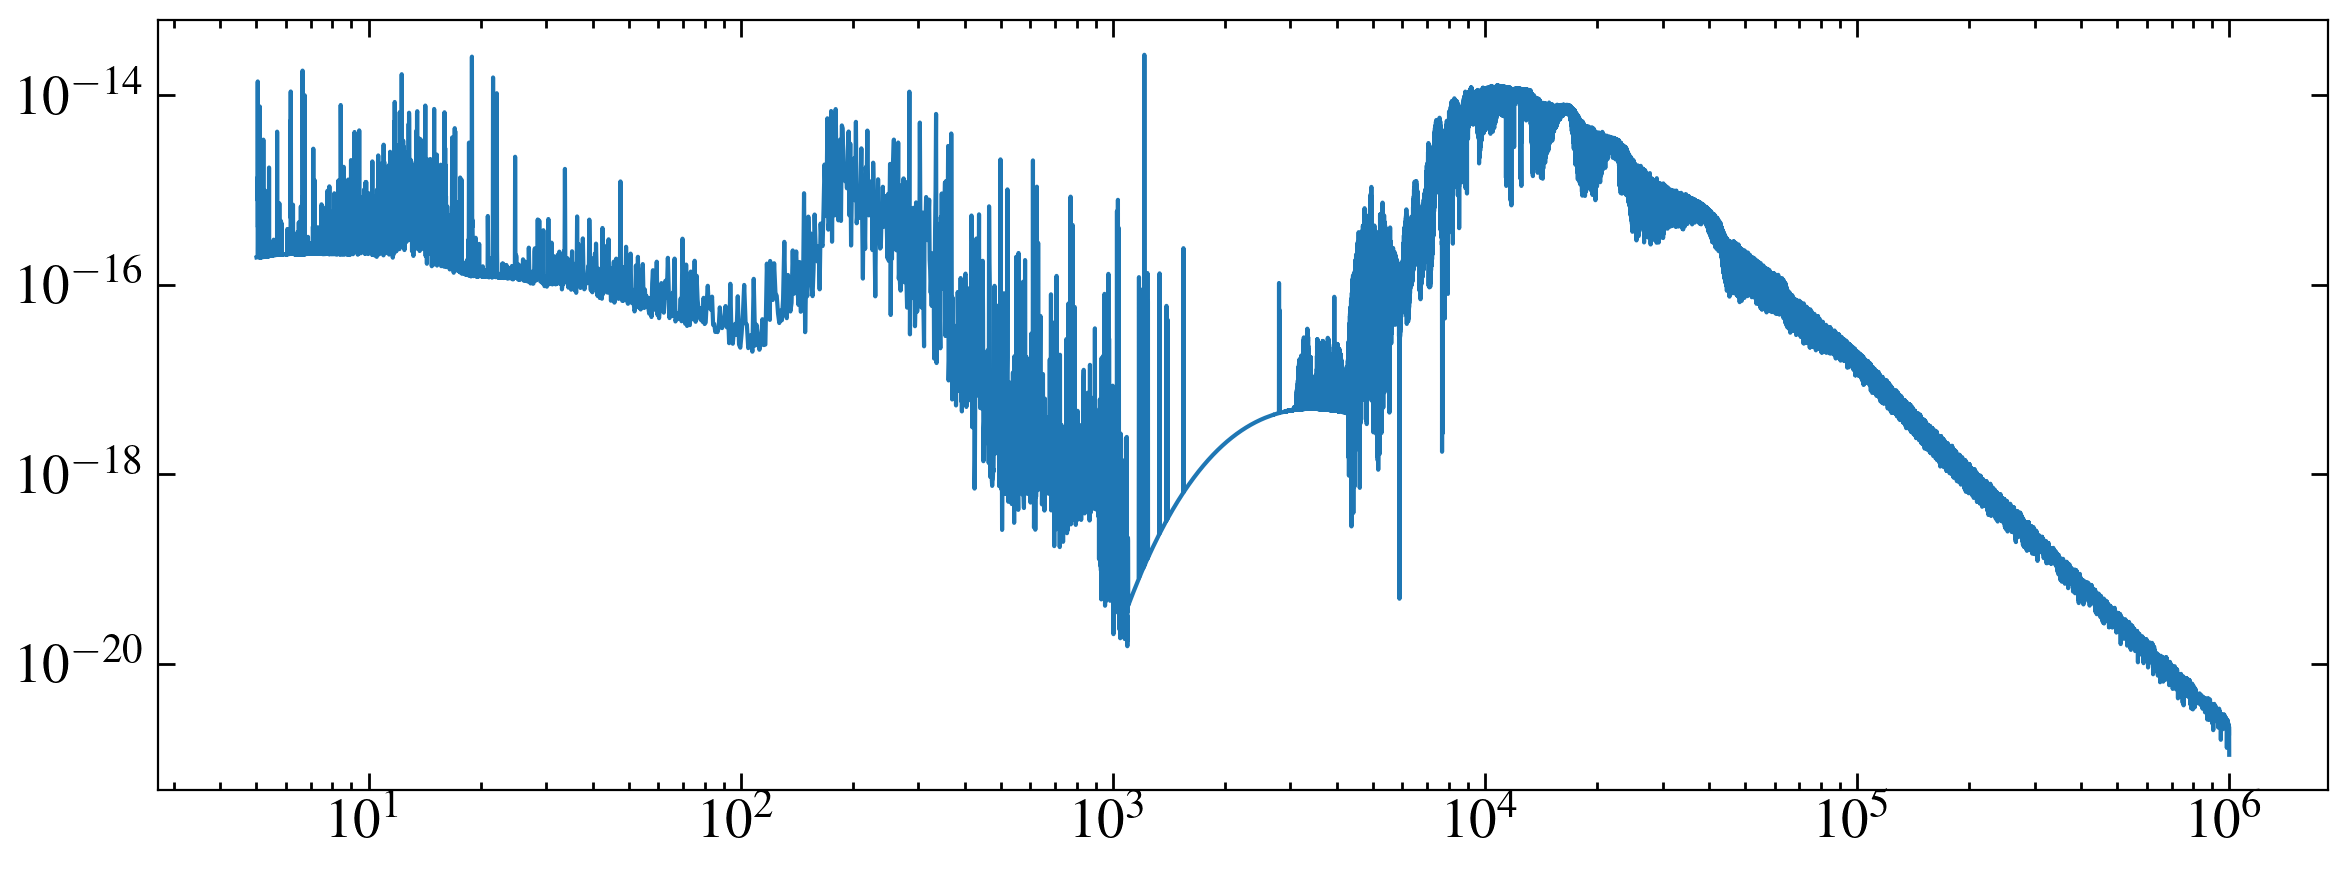

In [88]:
plt.plot(t1w, t1f)
plt.yscale('log')
plt.xscale('log')

In [89]:
oldmod = Table.read('../paper/saved_models/trappist-1_model_var_res_v07.ecsv')
ow, of = oldmod['WAVELENGTH'], oldmod['FLUX']

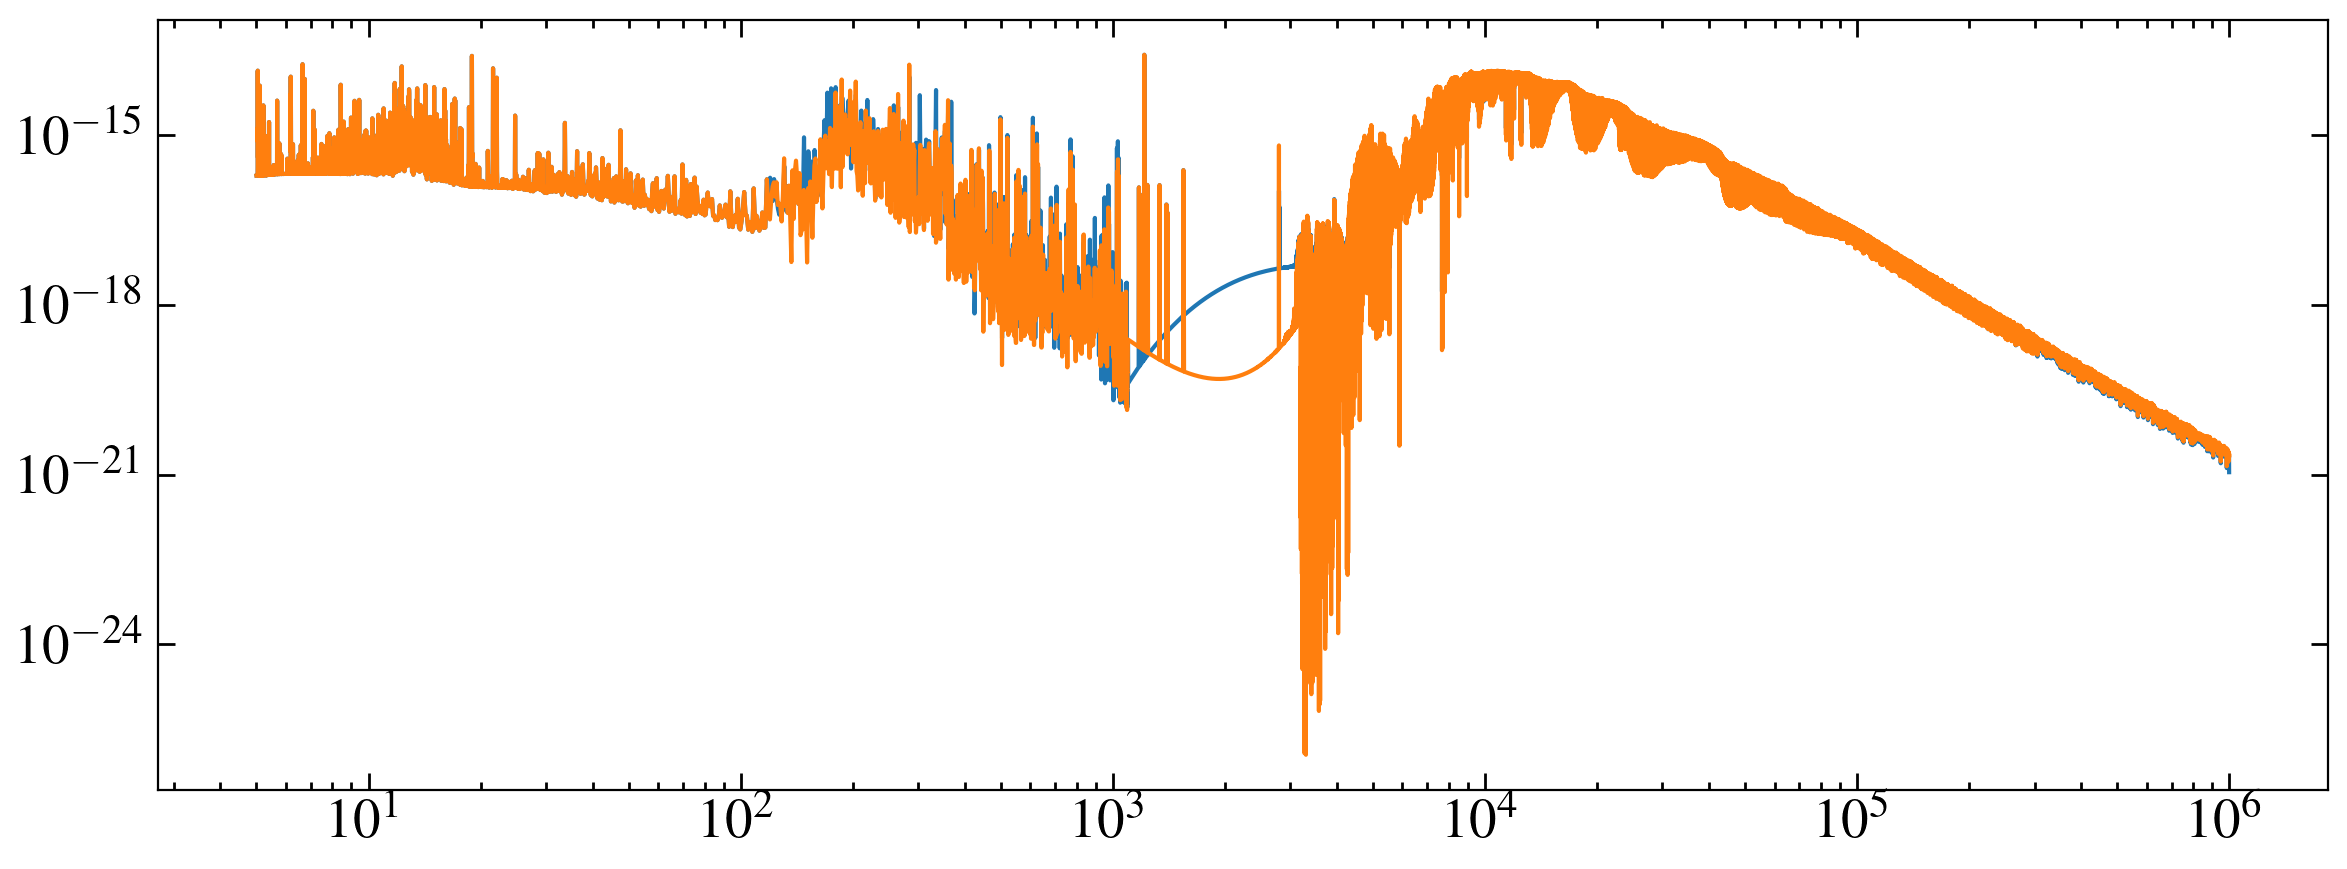

In [90]:
plt.plot(t1w, t1f)
plt.plot(ow, of)
plt.yscale('log')
plt.xscale('log')

In [93]:
savdat = Table([t1w*u.AA, t1f*u.erg/u.s/u.cm**2/u.AA], names= ['WAVELENGTH', 'FLUX'])
savdat.write('../paper/saved_models/trappist-1_model_var_res_v08.ecsv', overwrite=True, format='ascii.ecsv')

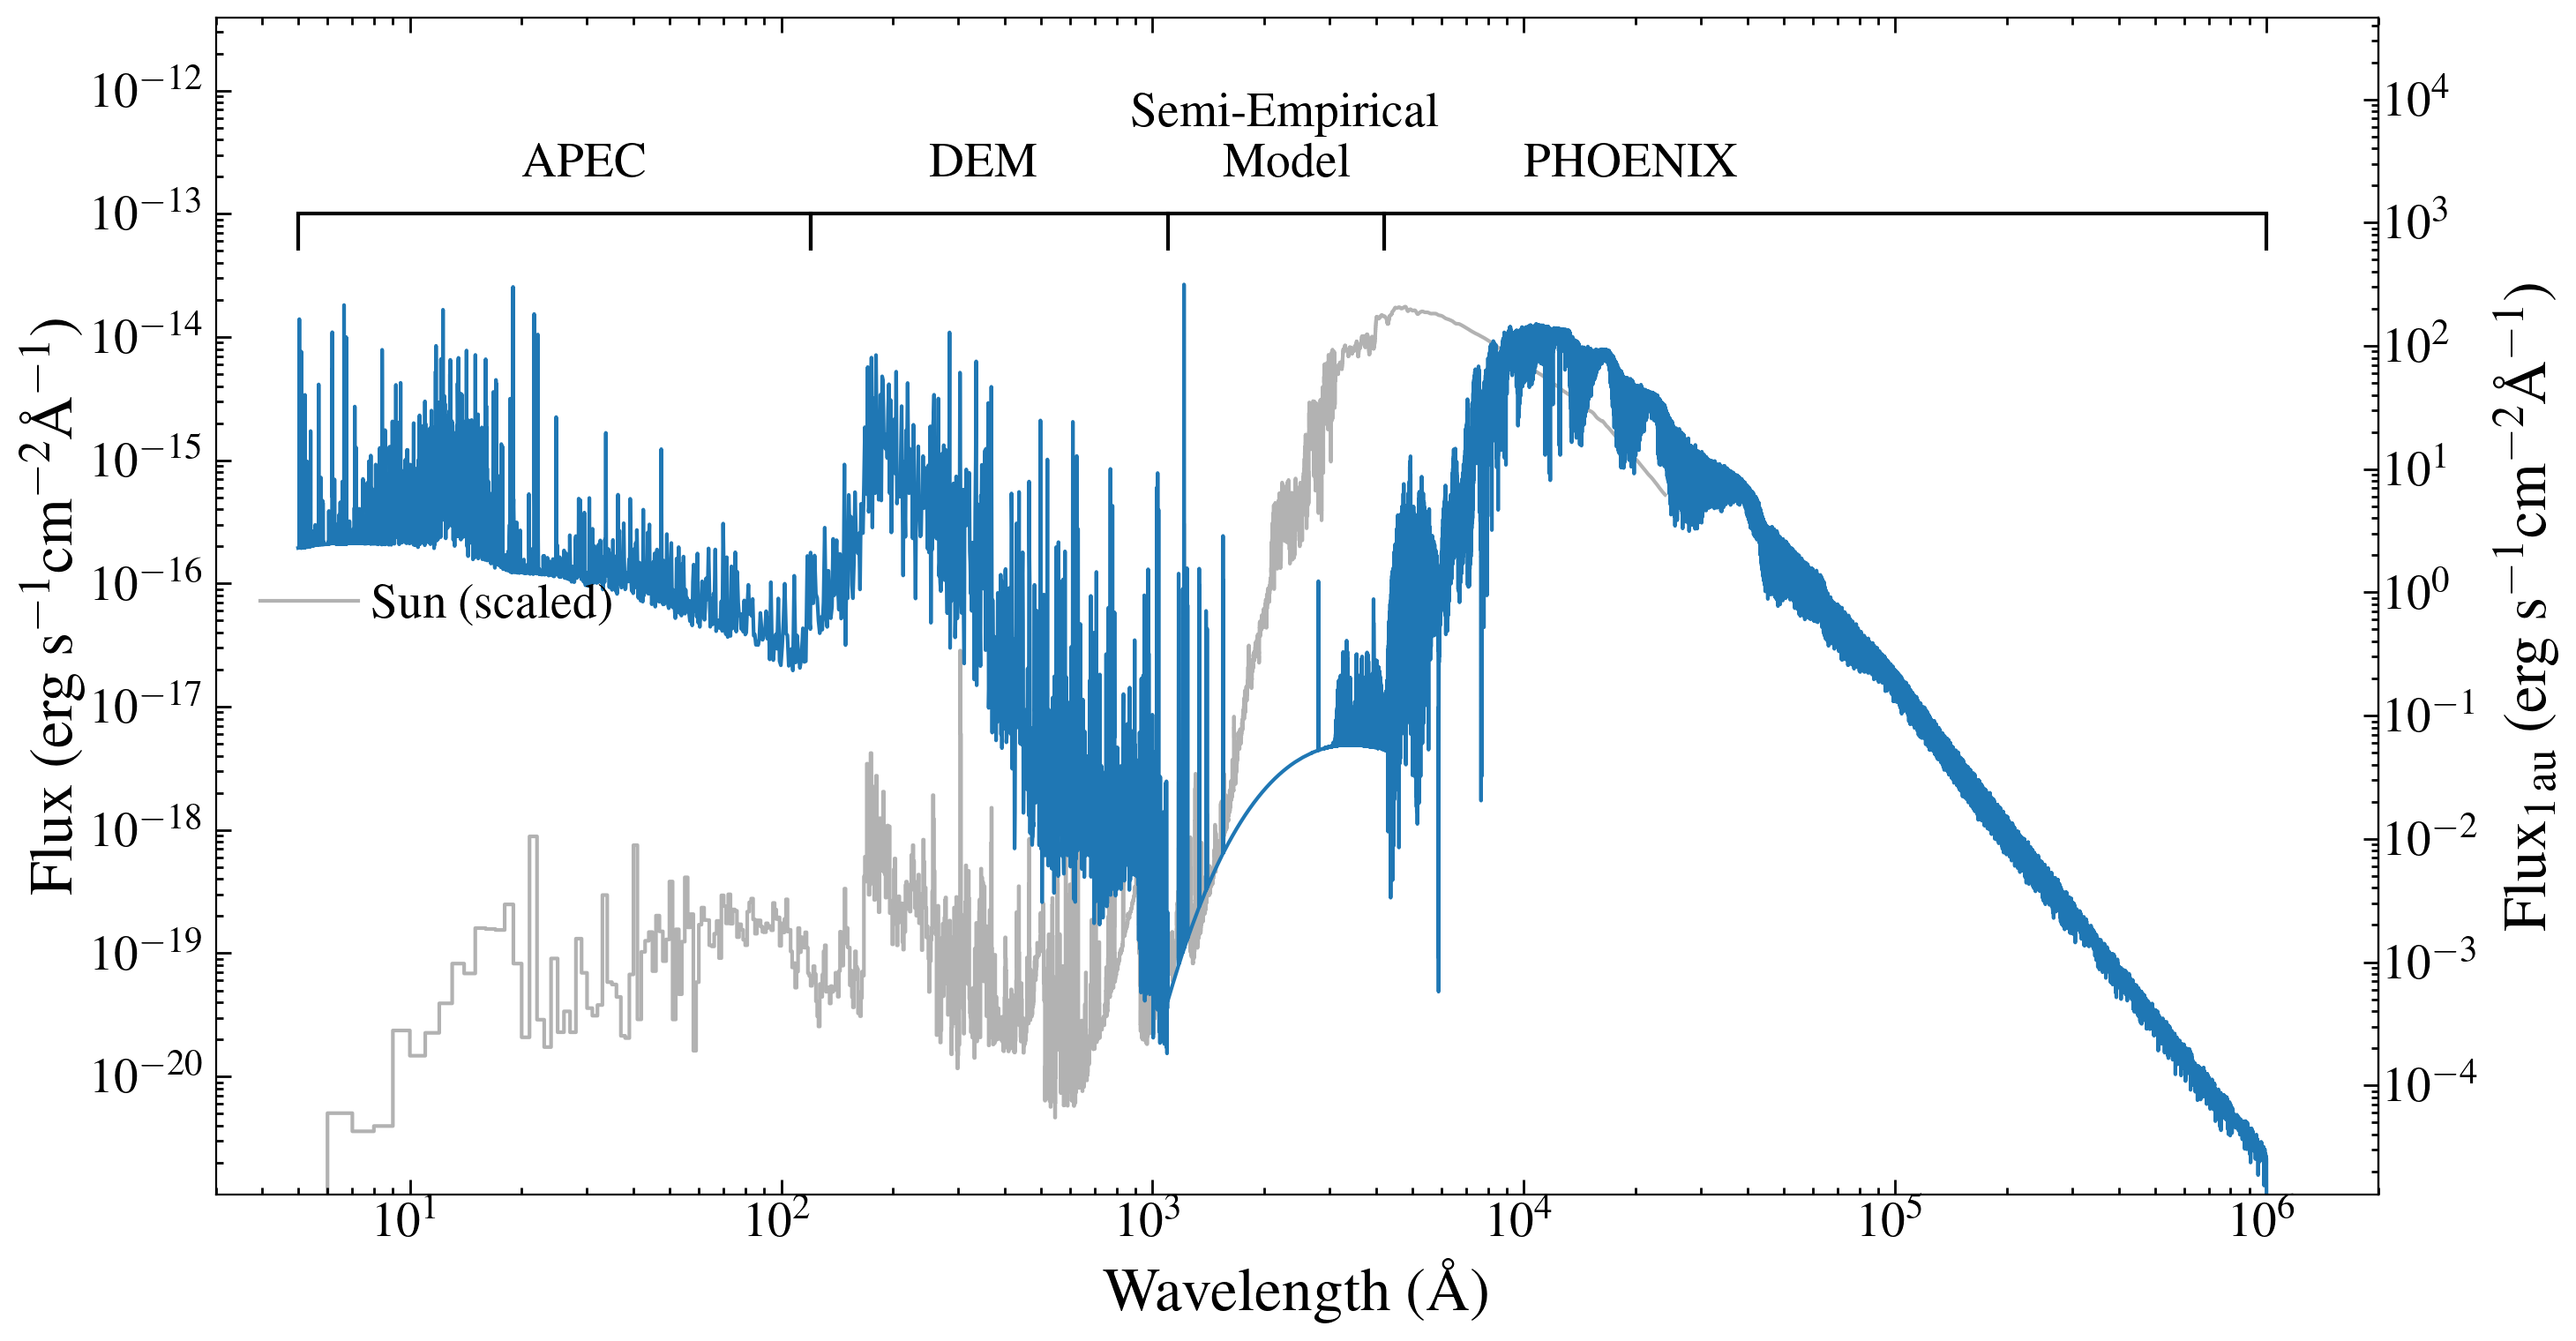

In [97]:
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from matplotlib.transforms import Transform

fig, ax = plt.subplots(figsize=(15, 8))
# plt.plot(aw, af)
# plt.plot(dw[(dw >aw[-1]) & (dw < 1100)], df[(dw >aw[-1]) & (dw < 1100)])
# plt.plot(mw, mf3)
# plt.plot(pw[(pw > 4200)], pf[(pw > 4200)])

plt.plot(t1w, t1f)

#plt.step(w,f/5, zorder=-5, c='0.5', where='mid')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(90, 10000)
#plt.errorbar((15,60),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
#plt.annotate('XMM', (20, 2e-13))



plt.errorbar((5,120),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('APEC', (20, 2e-13))

plt.errorbar((120,1100),(1e-13, 1e-13), yerr= [[5e-14,0],[0,0]], c ='k')
plt.annotate('DEM', (250, 2e-13))

plt.errorbar((1100, 4200),(1e-13, 1e-13), yerr= [[5e-14,5e-14],[0,0]], c ='k')
plt.annotate('Semi-Empirical\n Model', (2300, 2e-13), ha='center')

plt.errorbar((4200, 1000000),(1e-13, 1e-13), yerr= [[0,5e-14],[0,0]], c ='k')
plt.annotate('PHOENIX', (10000, 2e-13))

sol_spec =  readsav('../../../stuff/Solar-data.idlsav')
w_sol, f_sol = sol_spec['wave']*10, sol_spec['flux']*100
d_t1 = 12.1*u.pc 
d_sun = 1*u.au.to(u.pc)

#### scale by bolometric ps flux
r_t1 = 0.117*u.Rsun
#r_674 = 0.35*u.Rsun
t_t1= 2560*u.K
#t_674 = 3400*u.K
t_sun = 5777*u.k
bb_scale = (u.Rsun**2 * t_sun**4)/(r_t1**2 * t_t1**4)*(d_t1/d_sun)**2
plt.step(w_sol[w_sol>5], f_sol[w_sol>5]/bb_scale, zorder=-100, c='k', label = 'Sun (scaled)' , where='mid', alpha=0.3)

plt.ylim(1.1e-21, 3.9e-12)
plt.xlim(3, 2e6)
plt.xlabel('Wavelength (\AA)', size=25)
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)',size=25)
plt.legend(loc=6)

def t_to_s(x):
    return x*bb_scale.value

def s_to_t(x):
    return x/bb_scale.value

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False)      # ticks along the bottom edge are off   
secay = ax.secondary_yaxis('right', functions =(t_to_s, s_to_t))
#secay.yaxis.set_minor_locator(AutoMinorLocator())
secay.set_ylabel('Flux$_{\mathrm{ 1\,au}}$ (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size =25)


plt.tight_layout()
# plt.savefig('../plots/SEmp_v_sun.png', dpi= 150)
# plt.savefig('../plots/new_SEmp_v_sun.pdf', dpi= 150)